<a href="https://colab.research.google.com/github/igorleonel/DataScience/blob/main/Forecasting_em_S%C3%A9ries_Temporais_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

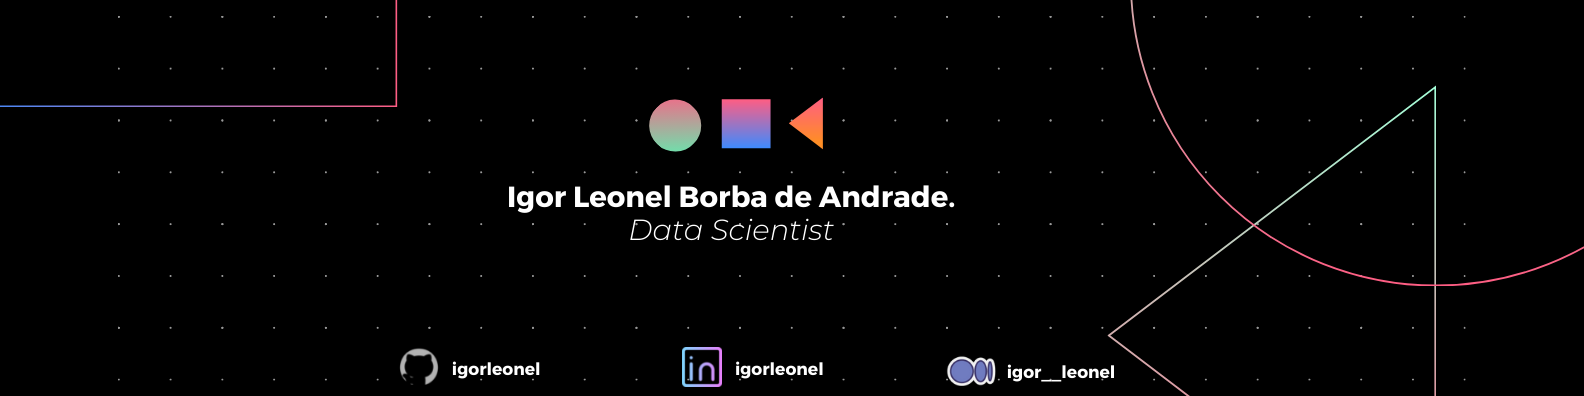

# Previsão de Séries Temporais com o Prophet

Neste projeto, irei trabalhar com séries temporais (*time series*) e a ferramenta ***Prophet***. Especificamente, farei a previsão relacionada ao desfecho (*outcomes*) de ***animais*** em um ***abrigo***

Antes de entrar no projeto em si, vamos conhecer o **Prophet** e o motivo dele ser tão poderoso para lidar com dados temporais.

## Prophet e Séries Temporais

Fazer boas previsões com dados temporais é uma tarefa altamente complexa. Dada a complexidade dos modelos estatísticos, *time series* representam um desafio para engenheiros de *machine learning*, **estatísticos** e **economistas**.

Tentar implementar um modelo sem usar nenhum *framework*, implica entender profundamente uma teoria que não é trivial e que exige um certo grau de especialização.

**Prophet** é um *framework* de forecasting* para séries temporais, disponibilizado como projeto *open source* pelo **Facebook**. Implementado em Python e R, é capaz de realizar previsões automatizadas e rápidas.

<p align="center"><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/prophet.png" height="300px"></p>

Como nem todos os problemas de *time series* podem ser resolvidos da mesma maneira - e o Prophet foi desenvolvido pensando-se nos problemas internos do Facebook -, é possível que cientistas e analistas de dados otimizem parâmetros do *framework*.

Para ter acesso a documentação oficial do projeto, basta [acessar esta página.](https://facebook.github.io/prophet/). Apesar de não haver muitos projetos e tutoriais, recomenda-se conhecer as customizações possíveis do modelo.

### Modelo Preditivo do Prophet

Como dissemos acima, o Prophet foi feito para solucionar problemas do Facebook. Ou seja, é muito forte para lidar com problemas que tenham características como:

* Dados coletados por um longo período (meses ou anos), e que possuam o maior detalhamento histórico possível.
* Sazonalidades fortes e destacadas.
* Feriados ou datas especiais conhecidas *a priori*.
* Tendência de crescimento não linear, que se aproxima de um limite.

Propeht usa um modelo de séries temporais decomposto, com três componentes principais: tendência, sazonalidade e feriados:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

onde:

* $g(t)$ é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
* $s(t)$ representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
* $h(t)$ representa os efeitos dos feriados; e
* $\varepsilon_t$ é o erro, as mudanças que não são capturadas pelo modelo (assume-se esse como tendo uma distribuição normal).

Lembrando, os parâmetros que estão definidos como *standard* atendem bem a maioria dos casos. No entanto, caso não tenham um *fit* adequado ao seu problema, esses podem ser ajustados manualmente

## O Problema de um Abrigo de Animais

O Centro de animais de Austin, no Texas, provê abriga para mais de 16 mil animais por ano, além de outros serviços envolvendo proteção de animais - independente da raça, idade ou estado de saúde desses.

Tendo como principal objetivo "destinar todos os animais possíveis para um novo lar, seja por meio de adoção, assistência social ou grupos de resgate."

Apesar desse objetivo, não é possível conseguir um lar para todos esse animais, e muitos acabam sendo sacrificados. A meta do Austin Animal Center é conseguir que o desfecho positivo, ou seja a saída com vida desses animais, seja superior a 90% do total.

Neste projeto, iremos analisar as saídas com vida desses animais. Com essa análise, espera-se que sejamos capazes de identificar um padrão de adoção.

Mais que identificar um padrão, espera-se fazer previsões futuras em relação ao número de saída do Austin Animal Center, visando:

1. Planejar compras de insumos (remédios, comida, etc);
2. Contratação de funcionários e colaboradores; e
3. Fazer campanhas visando otimizar a adoção de animais.

### Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado 23 de Maio de 2022 e contém **139K linhas** e **12 colunas**, onde

In [1]:
# importar as bibliotecas necessárias e setar configurações
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller

# melhorar a resolução
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# importar os dados para um DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/igorleonel/DataScience/main/datasets/Austin_Animal_Center_Outcomes%20(1).csv')

# converter a coluna DateTime para o formato conveniente
df['DateTime'] = pd.to_datetime(df.DateTime)

# visualizar as primeiras 5 entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,2020-08-16 11:38:00,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,2014-03-18 11:47:00,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [3]:
df[df['Breed'] == 'Pit Bull Mix']['Outcome Type'].value_counts()

Adoption           3709
Return to Owner    2934
Transfer           1785
Euthanasia          484
Rto-Adopt           109
Died                 26
Missing              14
Disposal              3
Name: Outcome Type, dtype: int64

In [4]:
df['Animal Type'].value_counts()

Dog          78598
Cat          52986
Other         7426
Bird           664
Livestock       25
Name: Animal Type, dtype: int64

## Análise Exploratória
Nosso *dataset* é composto por **12 variávels** (colunas), sendo com cada linha um animal registrado com Id, nome, data de entrada, animal, idade e entre outros. Temos no nosso conjunto de dados o evento por dia, e infelizmente alguns animais são sacrificados **(Euthanasia)** - no nosso modelo de séries temporais, iremos modelar a **saída** dos **animais** desse abrigo.  Segue as colunas:

* `Animal ID` - Identificador do animal
* `Name` - Nome do animal
* `DateTime` - Data e hora da adoção
* `MonthYear` - Mês e ano da adoção
* `Date of Birth` - Data de nascimento do animal
* `Outcome Type` - Tipos de resultados (saídas) possíveis
* `Outcome Subtype` - Status do animal
* `Animal Type` - Tipo do animal
* `Sex upon Outcome` - Sexo do animal após a adoção
* `Age upon Outcome` - Idade do animal após a adoção
* `Breed` - Raça do animal
* `Color` - Cor do animal

O primeiro animal registrado no Austin Animal Center foi em **01 de Outubro de 2013** sendo um cachorro da raça **Labrador Retriever Mix** da cor **preta** e o último animal registrado foi dia **23 de Maio de 2022** - um cachorro do sexo **feminino castrada** da raça **Labrador Retriever Mix** da cor **Castanho/Branco**. <p>
Em dois anos de registrados de animais, o **cachorro** está em primeiro lugar com mais **78 mil adotados/doados** seguido por **gatos** e **outros** tipos de animais; sendo assim, a raça de cachorro com mais frequência se dá ao **Pit Bull Mix** com a cor **Branco Azulado** sendo a maioria registrado por adoção.

In [5]:
# ver o resumo das principais informações estatísticas
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,139699,98305,139699,139699,139699,139676,63963,139699,139698,139688,139699,139699
unique,124918,23698,116101,104,7619,9,26,5,5,54,2751,619
top,A721033,Max,2016-04-18 00:00:00,Jun 2019,05/01/2016,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,623,39,2244,119,63902,33833,78598,49169,24132,32597,14583
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2022-05-23 13:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# ver um resumo dos tipos de variáveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139699 entries, 0 to 139698
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         139699 non-null  object        
 1   Name              98305 non-null   object        
 2   DateTime          139699 non-null  datetime64[ns]
 3   MonthYear         139699 non-null  object        
 4   Date of Birth     139699 non-null  object        
 5   Outcome Type      139676 non-null  object        
 6   Outcome Subtype   63963 non-null   object        
 7   Animal Type       139699 non-null  object        
 8   Sex upon Outcome  139698 non-null  object        
 9   Age upon Outcome  139688 non-null  object        
 10  Breed             139699 non-null  object        
 11  Color             139699 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 12.8+ MB


In [7]:
# verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                41394
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           23
Outcome Subtype     75736
Animal Type             0
Sex upon Outcome        1
Age upon Outcome       11
Breed                   0
Color                   0
dtype: int64

In [8]:
# ver os tipos de outcomes possíveis
df['Outcome Type'].value_counts()

Adoption           63902
Transfer           40547
Return to Owner    23107
Euthanasia          9188
Died                1311
Rto-Adopt            891
Disposal             633
Missing               72
Relocate              25
Name: Outcome Type, dtype: int64

Vamos analisar somente as adoções com duas condições: a primeira será quando o animal for adotado - e por arrenpedimento - o animal voltou para o dono. Depois, iremos criar uma coluna para auxiliar na contagem de animais por dia.

In [9]:
# Ver apenas os outcomes de adoção e retorno aos donos
adoptions_df = df[(df['Outcome Type'] == 'Adoption') | (df['Outcome Type'] == 'Return to Owner')]

# coluna auxiliar
adoptions_df['outcomeCount'] = 1
adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]

# para facilitar a manipulação, vamos transformar a data em index e colocar na sequência
adoptions_df = adoptions_df.set_index(adoptions_df['DateTime']).sort_index()

# excluir a coluna repetida
adoptions_df.drop('DateTime', axis='columns', inplace=True)
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:03:00,1
2013-10-01 11:42:00,1
2013-10-01 11:50:00,1
2013-10-01 11:53:00,1


In [10]:
# ver as datas míninas e máximas
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2022-05-23 13:34:00'))

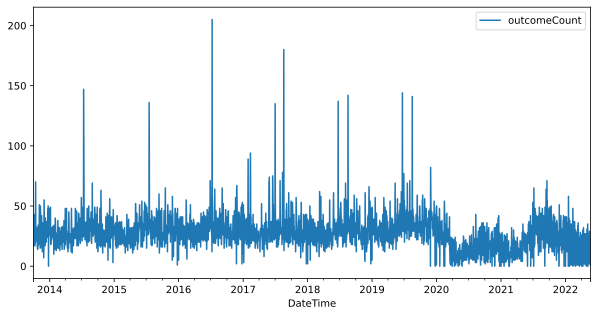

In [11]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10, 5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

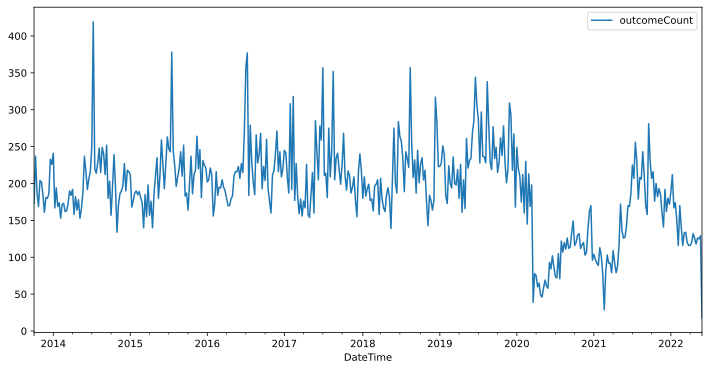

In [12]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(12, 6))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

### Preparar os Dados para o Prophet
Iremos criar dois modelos, um para dados diários e outro para dados semanais. O Prophet exige duas colunas: 'ds' e 'y', a coluna 'ds' é o tempo (o nosso index) e uma coluna 'y' para a quantidade por dia de animais

In [13]:
adoptions_df.resample('D').sum().head()

,outcomeCount
DateTime,
2013-10-01,24
2013-10-02,27
2013-10-03,17
2013-10-04,20
2013-10-05,43


In [14]:
# verificando o tipo 
type(adoptions_df.resample('D').sum().head())

pandas.core.frame.DataFrame

In [15]:
# trabalhar com dados diários
# ds (datetime)
# y (outcomeCount)
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount': 'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,24
1,2013-10-02,27
2,2013-10-03,17
3,2013-10-04,20
4,2013-10-05,43


### Teste ADF

O ADF é um dos testes estatísticos mais usados para TS. Suas hipóteses nula e alternativa são:

* A Hipótese Nula ($H_0$) do teste é que a TS não é estacionária. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Vamos realizar o ADF em cima do *dataset* que criamos - números de adoções e números de retorno aos donos.

In [16]:
# antes de criar o modelo de forecasting, é importante verificar se a série temporal é estacionária
adf = prophet_df.y.values

# aplicar ADF e imprimir o resultado
result = adfuller(adf)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('p_value {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
    print("\t{}: {:.4f}".format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -3.6392
p_value 0.0051
Valores Críticos:
	1%: -3.4324
	5%: -2.8625
	10%: -2.5673


Ao aplicar o teste de hipótese Dickey-Fuller, conseguimos um *p_value* igual a 0.005 (0.5%), ou seja, podemos rejeitar a hipótese nula ($H_0$), já que o *p-value* é menor que o nível de significância (5%). Neste caso, temos um valor de *p_value* baixo, o que significa que existe evidências suficientes para contrariar a hipótese nula. Sendo assim, estamos rejeitando a hipótese nula com um nível de confiança de 95%.

### Criar o Modelo de Forecasting

#### Modelo Diário

In [17]:
# antes de determinar o período de dias para previsão
prophet_df['ds'].min(), prophet_df['ds'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2022-05-23 00:00:00'))

In [18]:
# instanciar e treinar o modelo
model = Prophet()
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# depois de determinar o período de dias para previsão
future['ds'].min(), future['ds'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2023-05-23 00:00:00'))

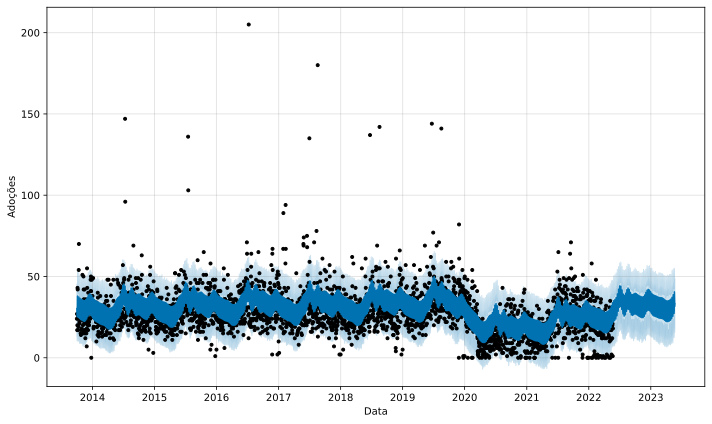

In [20]:
# visualizar o gráfico com as previsões 
model.plot(forecast, xlabel='Data', ylabel='Adoções');

O método de previsão atribuirá a cada linha no futuro um valor previsto que ele nomeia *yhat*. O objeto de previsão aqui é um novo dataframe que inclui uma coluna *yhat* com a previsão, bem como colunas para componentes e *intervalos* de *incerteza*.

In [21]:
# visualizando as previsões
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3517,2023-05-19,29.536009,14.818345,44.800508
3518,2023-05-20,40.513966,25.322022,55.051036
3519,2023-05-21,34.380076,18.729301,49.502633
3520,2023-05-22,31.614373,15.580093,48.069234
3521,2023-05-23,33.303152,18.020088,48.723384


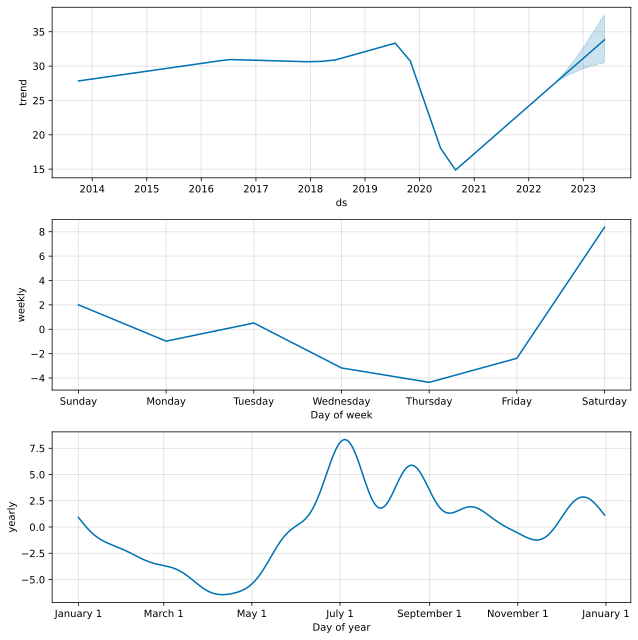

In [22]:
# separar os componentes do modelo
model.plot_components(forecast);

#### Modelo Semanal

In [23]:
# criar um modelo baseado em semanas 
prophet_df2 = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount': 'y'})

# instanciar e treinar o modelo
model2 = Prophet()
model2.fit(prophet_df2)

# determinar o período de dias para previsão
future2 = model2.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


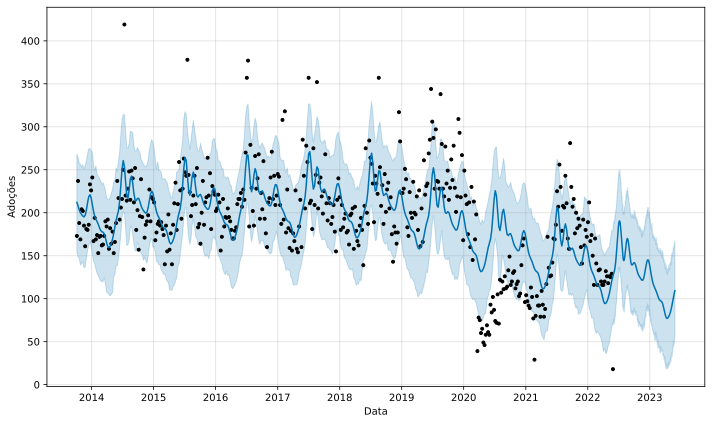

In [24]:
# visualizar o gráfico com as previsões
model2.plot(forecast2, xlabel='Data', ylabel='Adoções');

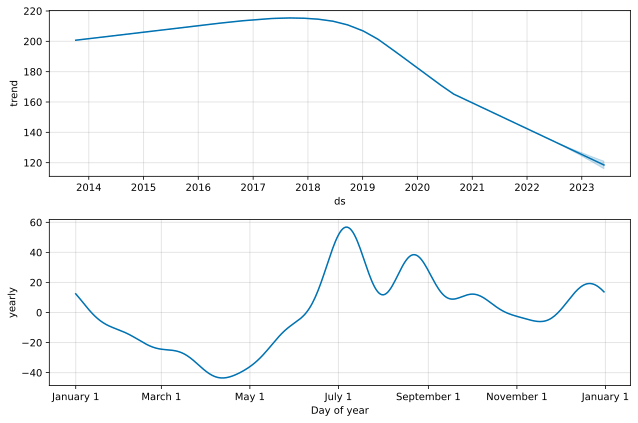

In [25]:
# separar os componentes do modelo
model2.plot_components(forecast2);

### Avaliação do Modelo de Séries Temporais

#### Modelo Diário

In [26]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2016-11-22 12:00:00 and 2021-05-23 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-11-23,26.849458,13.938052,39.950348,24,2016-11-22 12:00:00
1,2016-11-24,26.060506,13.958858,38.316188,2,2016-11-22 12:00:00
2,2016-11-25,27.322169,14.931674,40.381188,64,2016-11-22 12:00:00
3,2016-11-26,41.016725,27.981003,53.547225,67,2016-11-22 12:00:00
4,2016-11-27,39.163470,26.112235,51.795452,54,2016-11-22 12:00:00


In [27]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,247.822928,15.742393,11.601351,0.302735,0.709589
1,37 days 00:00:00,246.788577,15.709506,11.608367,0.302735,0.706849
2,37 days 12:00:00,245.944683,15.682624,11.571299,0.302735,0.709589
3,38 days 00:00:00,267.842628,16.365898,11.822657,0.302735,0.706849
4,38 days 12:00:00,266.195819,16.315509,11.752019,0.300830,0.709589


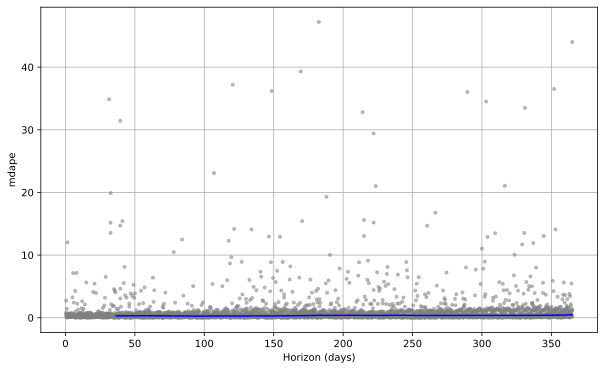

In [28]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mdape')

#### Modelo Semanal

INFO:fbprophet:Making 28 forecasts with cutoffs between 2015-04-06 00:00:00 and 2021-11-30 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 2015-04-12  176.449255  147.770606  206.679982  176 2015-04-06
1 2015-04-19  181.581231  150.495844  211.046929  140 2015-04-06
2 2015-04-26  175.903434  144.501069  208.120718  186 2015-04-06
3 2015-05-03  160.040528  129.675236  189.163578  211 2015-04-06
4 2015-05-10  152.224896  120.126029  183.298484  235 2015-04-06 

  horizon          mse       rmse        mae      mape     mdape  coverage
0 18 days  3098.418647  55.663441  41.036428  0.270490  0.169485  0.625000
1 19 days  3324.630475  57.659609  43.127118  0.292600  0.169485  0.611111
2 20 days  3653.589074  60.444926  43.971696  0.310236  0.155906  0.611111
3 21 days  3603.967790  60.033056  43.441190  0.307301  0.145622  0.625000
4 22 days  3629.501994  60.245348  42.911805  0.307203  0.142310  0.625000 



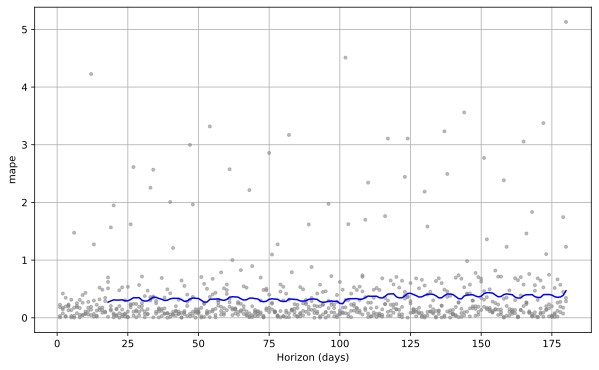

In [33]:
from fbprophet.diagnostics import cross_validation
df_cv2 = cross_validation(model2, horizon = '180 days')
print(df_cv2.head(), "\n")

from fbprophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
print(df_p2.head(), "\n")

from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv2, metric='mape');

#### Modelo Mensal

In [49]:
# criar um modelo baseado em semanas 
prophet_df3 = adoptions_df.resample('M').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount': 'y'})

# instanciar e treinar o modelo
model3 = Prophet()
model3.fit(prophet_df3)

# determinar o período de dias para previsão
future3 = model3.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast3 = model3.predict(future3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


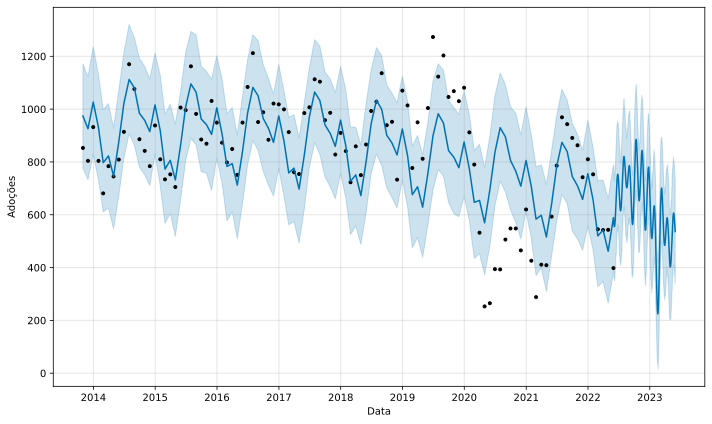

In [50]:
# visualizar o gráfico com as previsões
model3.plot(forecast3, xlabel='Data', ylabel='Adoções');

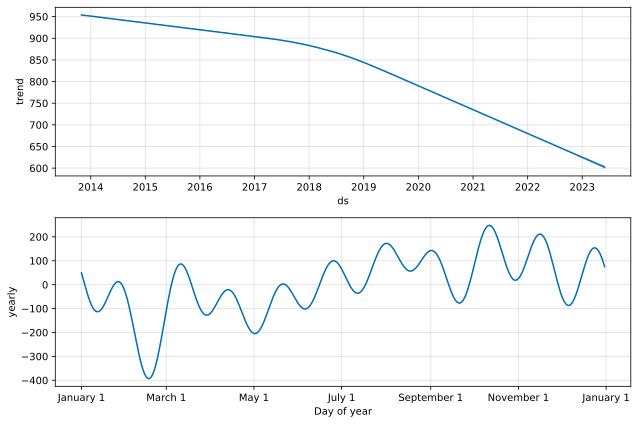

In [51]:
# separar os componentes do modelo
model3.plot_components(forecast3);

INFO:fbprophet:Making 27 forecasts with cutoffs between 2015-07-07 00:00:00 and 2021-12-02 00:00:00


  0%|          | 0/27 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


          ds         yhat   yhat_lower   yhat_upper     y     cutoff
0 2015-07-31   476.783844   476.152117   477.487791  1162 2015-07-07
1 2015-08-31   990.983330   988.630755   993.593131   982 2015-07-07
2 2015-09-30  1324.820459  1320.135650  1329.887303   885 2015-07-07
3 2015-10-31   639.395541   631.702633   647.882816   869 2015-07-07
4 2015-11-30   587.643847   576.713844   599.232595  1031 2015-07-07 

  horizon           mse        rmse         mae      mape     mdape  coverage
0 20 days  52037.743041  228.117827  141.808069  0.232366  0.088622   0.37500
1 22 days  66052.025701  257.005887  167.995776  0.283103  0.104879   0.37500
2 24 days  94615.521247  307.596361  202.840915  0.313857  0.122351   0.43750
3 25 days  96985.381706  311.424761  212.514815  0.326809  0.129352   0.37500
4 26 days  96436.117673  310.541652  207.693693  0.321435  0.129352   0.34375 



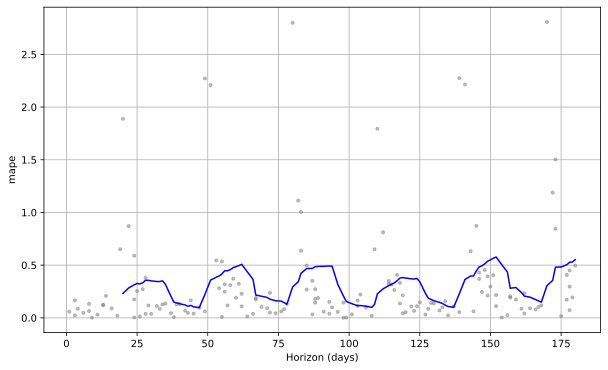

In [52]:
from fbprophet.diagnostics import cross_validation
df_cv3 = cross_validation(model3, horizon = '180 days')
print(df_cv3.head(), "\n")

from fbprophet.diagnostics import performance_metrics
df_p3 = performance_metrics(df_cv3)
print(df_p3.head(), "\n")

from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv3, metric='mape');

### Feriados e Datas Comemorativas

In [44]:
# Feriados e datas personalizadas
custom = pd.DataFrame(
    {
        'holiday': 'Nome do Feriado',
        'ds': pd.to_datetime(['2019-02-08', '2020-02-07']),
        'lower_window': 0,
        'upper_window': 1
     })

model4 = Prophet(holidays=custom)
model4.add_country_holidays(country_name='US')
model4.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
model3.train_holiday_names

0                 Nome do Feriado
1                  New Year's Day
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9                    Thanksgiving
10                  Christmas Day
11       Christmas Day (Observed)
12      New Year's Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
dtype: object

In [40]:
adoptions_df.resample('M').sum().reset_index().rename(columns={'DateTime': 'ds', 'outcomeCount': 'y'})

,ds,y
0,2013-10-31,853
1,2013-11-30,804
2,2013-12-31,932
3,2014-01-31,804
4,2014-02-28,681
...,...,...
99,2022-01-31,753
100,2022-02-28,545
101,2022-03-31,542
102,2022-04-30,543
